# Modeling Seagrass Habitats Using MaxEnt

#### by Orhun Aydin, PhD

In the previous section of the ESRI workshop, seagrass occurence from U.S. Marine Cadestre is used to define occurence and absence of seagrassesalong the U.S. coast to model seagrass habitats using Random Forest. In this section, we will test the validity of this assumption by modelling seagrass occurence using MaxEnt (maximum entropy) model. Currently, MaxEnt is not a geoprocessing tool. Thus, it will be integrated into the ArcGIS platform via the R-ArcGIS Bridge.

Below is the the workflow we will follow:

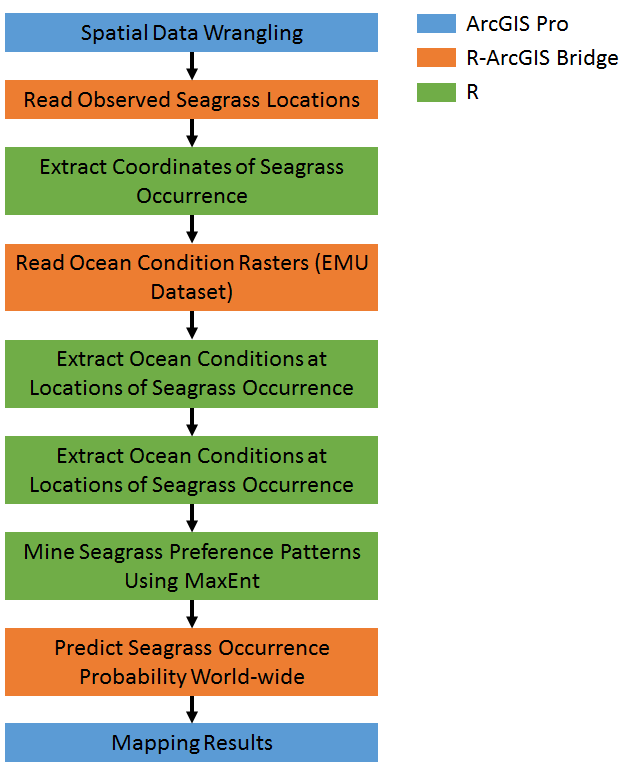

Import all necessary libraries, including arcgisbinding, the R library for R-ArcGIS Bridge. In this notebook, we will be using dismo, a species distribution modeling package, in addition to raster package for manipulating EMU data in R.

In [1]:
############################################################################################
################################### IMPORT R LIBRARIES FOR ANALYSIS ########################
############################################################################################
## Import R-ArcGIS Bridge
library(arcgisbinding)
## Run Check Product to Initialize the Bridge
arc.check_product()
## Import Raster Library
library(raster)
## Import Species Distribution Modeling Library
library(dismo)

Warning message:
"package 'arcgisbinding' was built under R version 3.5.0"*** Please call arc.check_product() to define a desktop license.


product: ArcGIS Pro ( 12.3.0.14444 )
license: Advanced 
version: 1.0.1.232

Loading required package: sp


## Read Observed Seagrass Locations
Observed Seagrass locations are read in from the feature class contained in ``` seagrass_in_r.gdb```. During the seminar, we created point location representation for seagrass occurence and saved the feature class as ```pointsUSCoast1000```.

Make sure that location pointing to the feature class is seperated with `\\` or `/`.

In [2]:
############################################################################################
####################################     READ IN DATA FROM ARCGIS   ########################
############################################################################################

## Open Prediction Points for U.S. Coast
seagrassObj <- arc.open('C:\\Users\\orhu8849\\Desktop\\Outreach\\Stanford\\seagrass_in_r.gdb\\pointsUSCoast1000')

## Bring In Only Occurence Data
seagrassData <- arc.select(seagrassObj, where_clause = "PRESENT = 0")

## Convert Data to Spatial Dataframe
seagrassSP <- arc.data2sp(seagrassData)
## Get Occurence Lat and Long
presence <- seagrassSP@coords

```seagrassObj``` is the descriptor for the feature class. This feature class models seagrass occurence as ```PRESENT=0``` and no observation as ```PRESENT=1```. In our analysis, we need locations that seagrasses grow thus using the ```arc.select``` function of the bridge we read in a subset of our dataset using the ```where_clause```. Lastly, ```data2sp``` converts the arc object into a spatial dataframe in R. Thus, we can querry the locations of seagrass occurence simply by calling ```@coords```.

## Read Ocean Condition Rasters (EMU Dataset)
Now that locations that seagrasses prefer are read in, the next step is obtaining information about habitat conditions at these locations. Firstly, we read in all the EMU rasters in a loop and create a stacked raster in R. We will plot the stacked rasters.

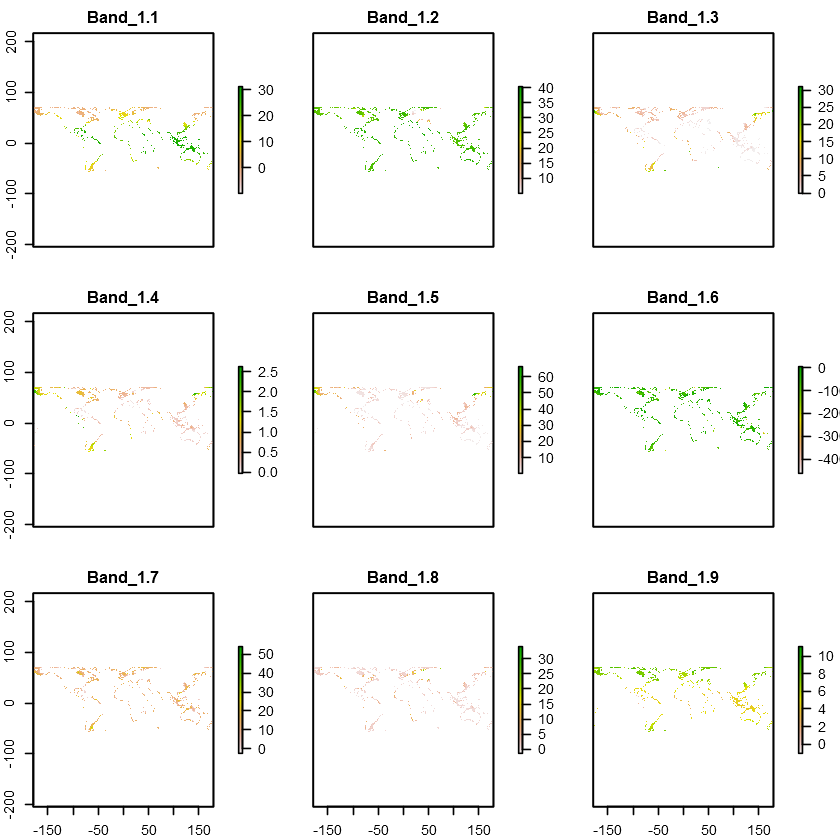

In [3]:
## Read In Prediction Rasters
varnames <- c('temp','salinity','nitrate','phosphate','silicate','srtm30','depth_lvl','ChlorA_12yrAvg', 'disso2')
rootGDB <- 'C:/Users/orhu8849/Desktop/GeoHab 2018/SeagrassPrediction/SeagrassPrediction.gdb'

## Define Extent to Read Rasters In
extent <- c(-179, -60, 179, 72)

## Read All the Rasters into One List
rList <- list()

for (i in 1:length(varnames)) {
    rasterObj <- arc.open(file.path(rootGDB, varnames[i]))
    raster <- arc.raster(rasterObj, extent = extent, nrow = 1000, ncol = 2000)

    rList[[i]] <- as.raster(raster)
}

## Create Multi-Dimensional Raster
rasters <- stack(rList)
plot(rasters)

In [4]:
############################################################################################
###################################     SDM VIA MAXENT    ######3###########################
############################################################################################
library(maxnet)

seagrassObj <- arc.open(file.path(rootGDB, 'seagrassRFTable'))

predictorFields <- c("DEPTH_LVL", "DISSO2", "NITRATE", "PHOSPHATE", "SALINITY", "SILICATE", "SRTM30", "TEMP", "CHLORA_12YRAVG") 

occurence <- arc.select(seagrassObj, fields = "PRESENT")
predictors <- arc.select(seagrassObj, fields = predictorFields)

In [ ]:
## CREATE MAXENT MODEL
maxEntModel <- maxnet(unlist(occurence), as.data.frame(predictors))

predPoints <- arc.select(arc.open(file.path(rootGDB, 'predictPoints')))

predPoints <- arc.data2sp(predPoints)

predVals <- extract(rasters, predPoints@coords)
predVals <- predVals[complete.cases(predVals),]
predVals <- as.data.frame(predVals)

colnames(predVals) <- predictorFields

In [ ]:
## PREDICT USING MAXENT
globalSeagrass <- predict(maxEntModel, predVals, clamp = T)

## CREATE OCCURENCE RASTER
predPoints$maxent <- NA
predictionIndexes <- as.numeric(rownames(predVals))
predPoints$maxent[predictionIndexes] <- globalSeagrass

In [ ]:
## WRITE THE OUTPUT TO RASTER
outputObj <- arc.write(file.path(rootGDB, 'maxEntPoints'),  predPoints)